# [Title] Benchmarking and Stepwise Fine-tuning using Transfer Learning for Bean Disease Classification with Pre-trained Convolutional Neural Networks

## Set Seed Value for Reproducibility

In [1]:
import random
import numpy as np
import tensorflow as tf
import os # Import os

# Set random seeds for reproducibility
SEED_VALUE = 200

os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

2025-05-20 15:56:25.250370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747756585.460888      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747756585.520936      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Dataset loading and augmentation setup

In [2]:
# Dataset loading and augmentation setup

import tensorflow as tf
import pathlib
import zipfile
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, EfficientNetB0, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet121
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnetb0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from tensorflow.keras.callbacks import EarlyStopping

# Dataset setup
base_path = pathlib.Path("/kaggle/working/datasets")
base_path.mkdir(parents=True, exist_ok=True)

def download_and_extract(url, extract_to):
    filename = url.split("/")[-1]
    zip_path = tf.keras.utils.get_file(filename, origin=url, extract=False)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(path=extract_to)

# Download datasets
download_and_extract("https://storage.googleapis.com/ibeans/train.zip", base_path)
download_and_extract("https://storage.googleapis.com/ibeans/validation.zip", base_path)
download_and_extract("https://storage.googleapis.com/ibeans/test.zip", base_path)

train_dir = base_path / "train"
val_dir = base_path / "validation"
test_dir = base_path / "test"

# Load datasets with consistent image size
BATCH_SIZE = 32
IMG_SIZE = (224, 224) # Consistent size for VGG16, ResNet50, DenseNet121, EfficientNetB0, MobileNetV2
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print("Datasets loaded and prefetching configured.")

# Define Data Augmentation Pipeline
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomBrightness(factor=0.15)
], name="data_augmentation")

print("Data augmentation pipeline defined.")

143812152/143812152 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
18504213/18504213 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
17708541/17708541 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 1034 files belonging to 3 classes.


I0000 00:00:1747756604.920542      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747756604.921213      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.
Datasets loaded and prefetching configured.
Data augmentation pipeline defined.


## Visualize Sample Images from the Dataset

Saved Figure_Dataset_Samples.tiff


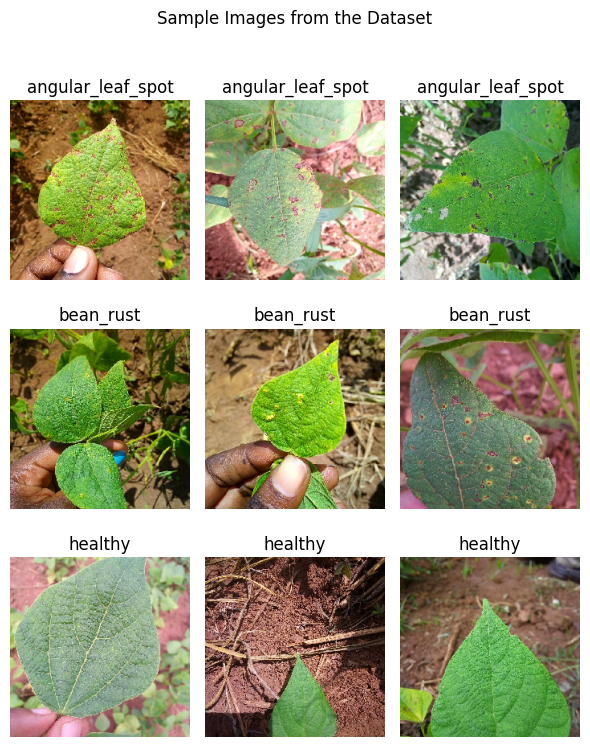

Sample Images Visualized and Saved


In [3]:
# Visualize Sample Images from the Dataset

# Define the number of samples to show per class
num_samples_per_class = 3

def get_samples_from_dir(directory, class_names, num_samples_per_class):
    samples = []
    for class_name in class_names:
        class_dir = directory / class_name
        image_files = list(class_dir.glob('*.jpg'))
        # Select a random files from the list
        selected_files = random.sample(image_files, min(num_samples_per_class, len(image_files)))
        for file in selected_files:
            img = tf.keras.utils.load_img(file, target_size=IMG_SIZE)
            img_array = tf.keras.utils.img_to_array(img)
            samples.append((img_array, class_name))
    return samples

# Get samples from the training directory
sample_images = get_samples_from_dir(train_dir, class_names, num_samples_per_class)

n_cols = num_samples_per_class
n_rows = len(class_names)
plt.figure(figsize=(n_cols * 2, n_rows * 2.5))

for i, (image, class_name) in enumerate(sample_images):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.suptitle("Sample Images from the Dataset", y=1.02)
plt.tight_layout()

# Save the figure as TIFF with 300 DPI
save_filename = 'Figure_Dataset_Samples.tiff'
plt.savefig(save_filename, dpi=300, format='tiff', bbox_inches='tight')
print(f"Saved {save_filename}")
plt.show()
plt.close()

print("Sample Images Visualized and Saved")

## Benchmarking Transfer Learning on 5 CNN models

In [4]:
# Transfer Learning Benchmarking

# Set input shape (224, 224, 3) as it's consistent for all models
models_to_benchmark = {
    "VGG16": (VGG16, preprocess_vgg16),
    "ResNet50": (ResNet50, preprocess_resnet50),
    "DenseNet121": (DenseNet121, preprocess_densenet121),
    "EfficientNetB0": (EfficientNetB0, preprocess_efficientnetb0),
    "MobileNetV2": (MobileNetV2, preprocess_mobilenetv2),
}

# Define the consistent input shape for all models
INPUT_SHAPE = (224, 224, 3)

# Set up Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

print("Early Stopping callback configured.")

benchmarking_results = {}
training_histories = {}

# Set maximum training epochs
EPOCHS = 20

for model_name, (base_model_creator, preprocess_func) in models_to_benchmark.items():
    print(f"Benchmarking {model_name}")
    
    # Load the pre-trained base model without classification layer
    base_model = base_model_creator(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

    # Freeze the weights of the base model
    base_model.trainable = False

    # Define the input layer
    inputs = tf.keras.Input(shape=INPUT_SHAPE)

    # Apply data augmentation pipeline
    x = data_augmentation(inputs)
    x = preprocess_func(x)

    # Pass the processed data through the base model
    x = base_model(x, training=False)

    # Add a Global Average Pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Add the final Dense output layer for classification
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

    # Create the complete Keras Model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Model Training

    print(f"Training {model_name}...")
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[early_stopping]
    )

    # Store the training history (loss and metrics over epochs)
    training_histories[model_name] = history.history

    # Model Evaluation
    print(f"Evaluating {model_name} on the test set...")
    loss, accuracy = model.evaluate(test_ds)
    print(f"{model_name} Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Store the final test accuracy
    benchmarking_results[model_name] = accuracy

print("Benchmarking Complete")
print("\nBenchmarking Summary:")
for model_name, accuracy in benchmarking_results.items():
    print(f"{model_name}: {accuracy:.4f}")

# Find and print the best performing model based on test accuracy
if benchmarking_results:
    best_model_name = max(benchmarking_results, key=benchmarking_results.get)
    print(f"\nBest performing model on test accuracy: {best_model_name} with accuracy {benchmarking_results[best_model_name]:.4f}")

Early Stopping callback configured.
Benchmarking VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training VGG16...
Epoch 1/20


I0000 00:00:1747756614.467224      68 cuda_dnn.cc:529] Loaded cuDNN version 90300


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.3185 - loss: 2.6325 - val_accuracy: 0.6165 - val_loss: 0.9497
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.6515 - loss: 0.9013 - val_accuracy: 0.7218 - val_loss: 0.6554
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.7099 - loss: 0.7149 - val_accuracy: 0.8195 - val_loss: 0.4686
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.7769 - loss: 0.5594 - val_accuracy: 0.8421 - val_loss: 0.4254
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.8054 - loss: 0.4905 - val_accuracy: 0.8120 - val_loss: 0.4835
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.8281 - loss: 0.4482 - val_accuracy: 0.8496 - val_loss: 0.3345
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.8334 - loss: 0.4617 - val_accuracy: 0.8496 - val_loss: 0.3235
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.8486 - loss: 0.3711 - val_accuracy: 0.8722 - val

E0000 00:00:1747757041.829812      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - accuracy: 0.4931 - loss: 0.9968 - val_accuracy: 0.7068 - val_loss: 0.7144
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.7650 - loss: 0.6275 - val_accuracy: 0.7895 - val_loss: 0.5792
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.8129 - loss: 0.5271 - val_accuracy: 0.7970 - val_loss: 0.5154
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.8414 - loss: 0.4663 - val_accuracy: 0.7970 - val_loss: 0.4736
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8683 - loss: 0.4075 - val_accuracy: 0.7895 - val_loss: 0.4586
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8798 - loss: 0.3841 - val_accuracy: 0.7970 - val_loss: 0.4240
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8920 - loss: 0.3504 - val_accuracy: 0.8120 - val_loss: 0.3965
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9036 - loss: 0.3252 - val_accuracy: 0.8195 - val_loss: 

## Plot Benchmarking Histories of 5 CNN Models

Visualizing and Saving Benchmarking Training Histories
Plotting history for VGG16...
Saved Figure1_VGG16_Benchmarking_History.tiff


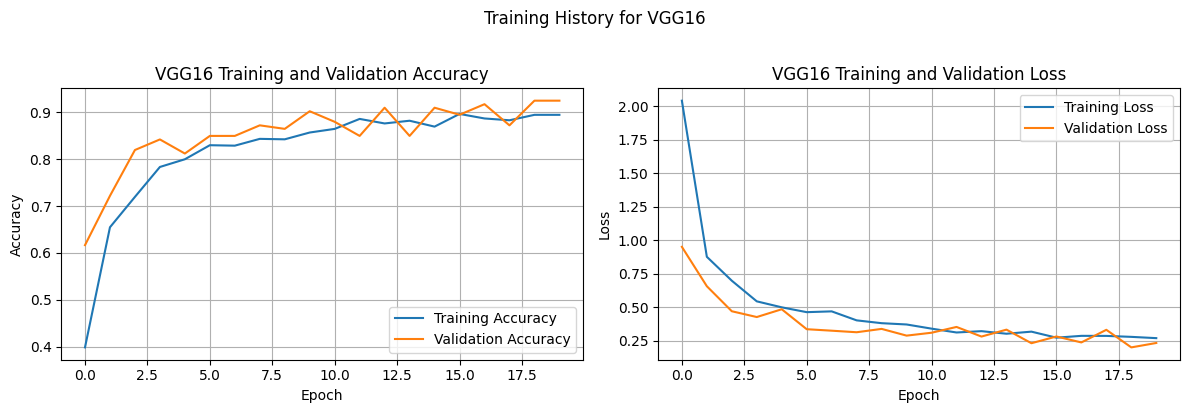

Plotting history for ResNet50...
Saved Figure1_ResNet50_Benchmarking_History.tiff


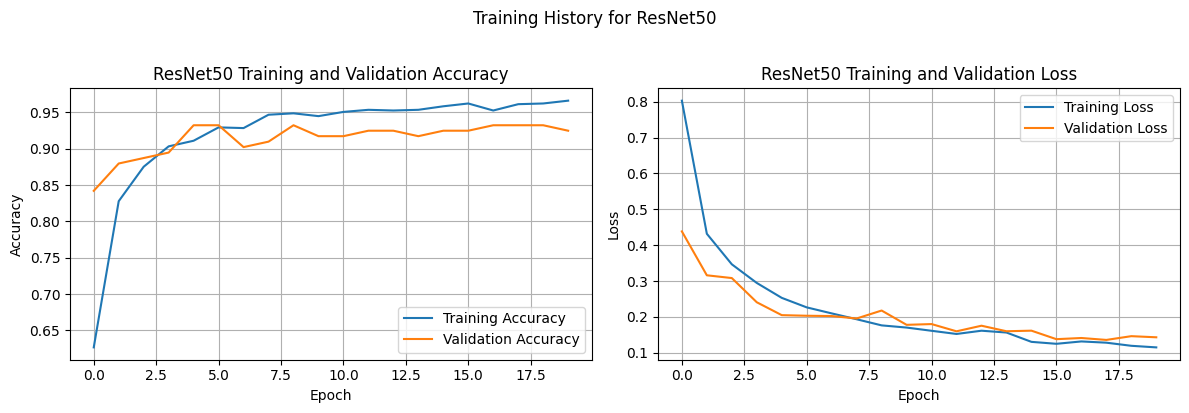

Plotting history for DenseNet121...
Saved Figure1_DenseNet121_Benchmarking_History.tiff


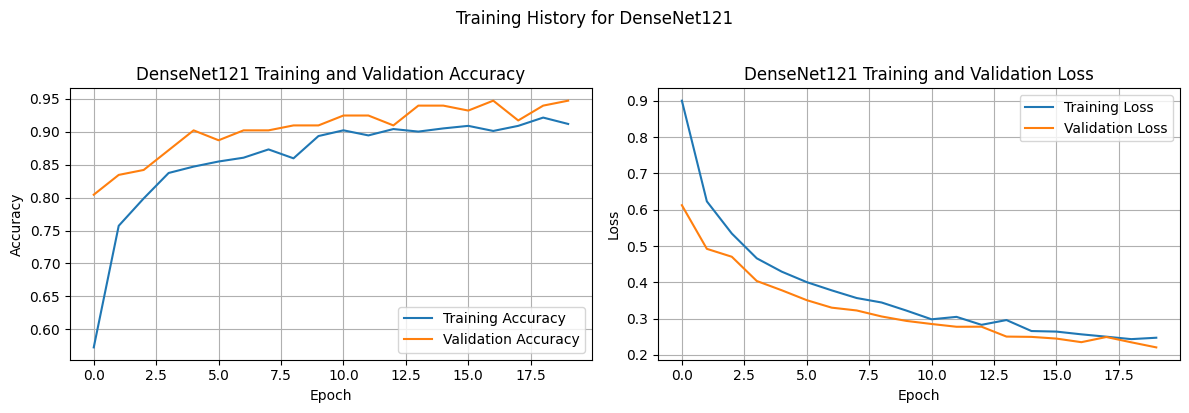

Plotting history for EfficientNetB0...
Saved Figure1_EfficientNetB0_Benchmarking_History.tiff


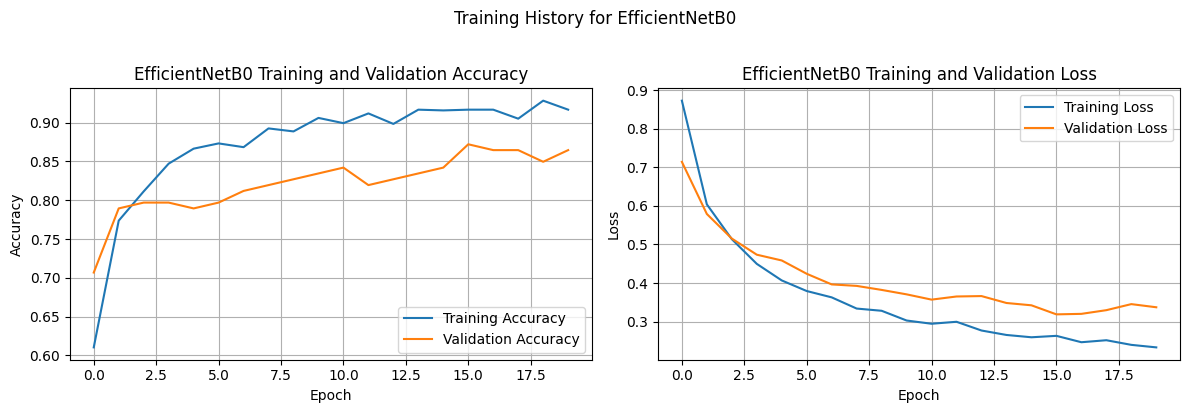

Plotting history for MobileNetV2...
Saved Figure1_MobileNetV2_Benchmarking_History.tiff


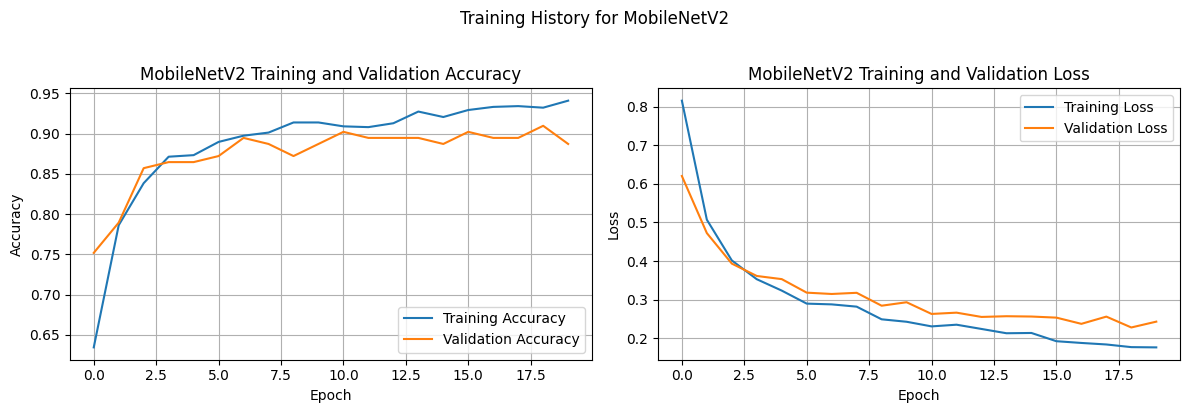

Benchmarking History Plots Saved


In [5]:
# Plot Benchmarking Histories of 5 CNN Models

print("Visualizing and Saving Benchmarking Training Histories")

metrics_to_plot = ['accuracy', 'loss']

for model_name, history in training_histories.items():
    print(f"Plotting history for {model_name}...")
    epochs = range(len(history[metrics_to_plot[0]]))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Plot Accuracy on the first axis (axes[0])
    axes[0].plot(epochs, history['accuracy'], label='Training Accuracy')
    axes[0].plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title(f'{model_name} Training and Validation Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Loss on the second axis (axes[1])
    axes[1].plot(epochs, history['loss'], label='Training Loss')
    axes[1].plot(epochs, history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{model_name} Training and Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle(f'Training History for {model_name}', y=1.02)
    fig.tight_layout()

    # Save the figure in tiff format with 300 DPI
    save_filename = f'Figure1_{model_name}_Benchmarking_History.tiff'
    fig.savefig(save_filename, dpi=300, format='tiff', bbox_inches='tight')
    print(f"Saved {save_filename}")
    plt.show(fig)
    plt.close(fig)

print("Benchmarking History Plots Saved")

In [6]:
base_model.layers
# base_model.summary()

[<InputLayer name=input_layer_9, built=True>,
 <Conv2D name=Conv1, built=True>,
 <BatchNormalization name=bn_Conv1, built=True>,
 <ReLU name=Conv1_relu, built=True>,
 <DepthwiseConv2D name=expanded_conv_depthwise, built=True>,
 <BatchNormalization name=expanded_conv_depthwise_BN, built=True>,
 <ReLU name=expanded_conv_depthwise_relu, built=True>,
 <Conv2D name=expanded_conv_project, built=True>,
 <BatchNormalization name=expanded_conv_project_BN, built=True>,
 <Conv2D name=block_1_expand, built=True>,
 <BatchNormalization name=block_1_expand_BN, built=True>,
 <ReLU name=block_1_expand_relu, built=True>,
 <ZeroPadding2D name=block_1_pad, built=True>,
 <DepthwiseConv2D name=block_1_depthwise, built=True>,
 <BatchNormalization name=block_1_depthwise_BN, built=True>,
 <ReLU name=block_1_depthwise_relu, built=True>,
 <Conv2D name=block_1_project, built=True>,
 <BatchNormalization name=block_1_project_BN, built=True>,
 <Conv2D name=block_2_expand, built=True>,
 <BatchNormalization name=block

## Stepwise Fine-tuning of the Best Model (ResNet50) - Block-based

In [7]:
# Stepwise Fine-tuning of the Best Model (ResNet50) - Block-based

print("Starting Block-based Stepwise Fine-tuning of ResNet50")

# Define the base model creator and preprocessor for ResNet50
best_model_creator = ResNet50
best_preprocess_func = preprocess_resnet50
best_model_name = "ResNet50"

# Input shape for ResNet50
INPUT_SHAPE = (224, 224, 3)

base_model = best_model_creator(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

finetuning_history = {}

# Step 1: Train only the classification head (Base model frozen)

print("Step 1: Training classification head (Frozen Base)")

# Freeze the base model layers
base_model.trainable = False

# Define the complete model structure with augmentation, preprocessing, base model, and new head
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
x = best_preprocess_func(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Training Step 1...")
# Train the model
history_step1 = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping]
)
finetuning_history['step1'] = history_step1.history

print("Step 1 training complete. Last epoch:", history_step1.epoch[-1])

# Step 2: Unfreeze and fine-tune the conv5 stage

print("Step 2: Fine-tuning conv5 stage")

# Find the first layer name that starts with 'conv5_'
unfreeze_from_layer_name_step2 = None
for i, layer in enumerate(base_model.layers):
    if layer.name.startswith('conv5_'):
        unfreeze_from_layer_name_step2 = layer.name
        break

if unfreeze_from_layer_name_step2:
    print(f"Unfreezing layers from '{unfreeze_from_layer_name_step2}' onwards.")
    # Unfreeze the base model initially
    base_model.trainable = True

    # Freeze all layers up to the start of the conv5 stage
    set_trainable = False
    for layer in base_model.layers:
        if layer.name == unfreeze_from_layer_name_step2:
            set_trainable = True
        layer.trainable = set_trainable

    # Recompile the model with a lower learning rate for fine-tuning
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Continue training from where it left off in Step 1
    print("Training Step 2...")
    history_step2 = model.fit(
        train_ds,
        epochs=history_step1.epoch[-1] + 20,
        initial_epoch=history_step1.epoch[-1] + 1,
        validation_data=val_ds,
        callbacks=[early_stopping]
    )
    finetuning_history['step2'] = history_step2.history
    print("Step 2 training complete. Last epoch:", history_step2.epoch[-1])

else:
    print("Could not find the start of the conv5 stage. Skipping Step 2.")
    finetuning_history['step2'] = None

# Step 3: Unfreeze and fine-tune the conv4 and conv5 stages

print("Step 3: Fine-tuning conv4 and conv5 stages")

# Find the layers in conv4 stage
unfreeze_from_layer_name_step3 = None
for i, layer in enumerate(base_model.layers):
    if layer.name.startswith('conv4_'):
        unfreeze_from_layer_name_step3 = layer.name
        break

if unfreeze_from_layer_name_step3:
    print(f"Unfreezing layers from '{unfreeze_from_layer_name_step3}' onwards.")

    # Check if the base model is trainable or not before freezing layers
    base_model.trainable = True

    # Freeze all layers up to the start of the conv4 stage
    set_trainable = False
    for layer in base_model.layers:
         if layer.name == unfreeze_from_layer_name_step3:
            set_trainable = True
         layer.trainable = set_trainable

    # Recompile the model with an even lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    last_completed_epoch = history_step1.epoch[-1]
    if finetuning_history['step2'] is not None:
         last_completed_epoch = history_step2.epoch[-1]

    print("Training Step 3...")
    history_step3 = model.fit(
        train_ds,
        epochs=last_completed_epoch + 30,
        initial_epoch=last_completed_epoch + 1,
        validation_data=val_ds,
        callbacks=[early_stopping]
    )
    finetuning_history['step3'] = history_step3.history
    print("Step 3 training complete. Last epoch:", history_step3.epoch[-1])

else:
    print("Could not find the start of the conv4 stage. Skipping Step 3.")
    finetuning_history['step3'] = None


# Evaluation after Fine-tuning

print("Evaluating ResNet50 after Fine-tuning")

# Evaluate the step-wise fine-tuned model
loss, accuracy = model.evaluate(test_ds)
print(f"{best_model_name} Fine-tuned Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

final_finetuned_accuracy = accuracy

print("ResNet50 Stepwise Fine-tuning Complete")

Starting Block-based Stepwise Fine-tuning of ResNet50
Step 1: Training classification head (Frozen Base)
Training Step 1...
Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 272ms/step - accuracy: 0.5403 - loss: 0.9627 - val_accuracy: 0.8496 - val_loss: 0.4196
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.8471 - loss: 0.4287 - val_accuracy: 0.8947 - val_loss: 0.2976
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.8868 - loss: 0.3282 - val_accuracy: 0.9098 - val_loss: 0.2510
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.8923 - loss: 0.2957 - val_accuracy: 0.9098 - val_loss: 0.2464
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.8978 - loss: 0.2812 - val_accuracy: 0.9023 - val_loss: 0.2319
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.9293 - loss: 0.2218 - val_accuracy: 0.9173 - val_loss: 0.2100
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.9327 - loss: 0.2138 - val_accuracy: 0.909

## Plot Combined Fine-tuning History for ResNet50 with Step 1, 2, 3 Highlights and Save as TIFF

Saved ResNet50_finetuning_history_highlighted.tiff


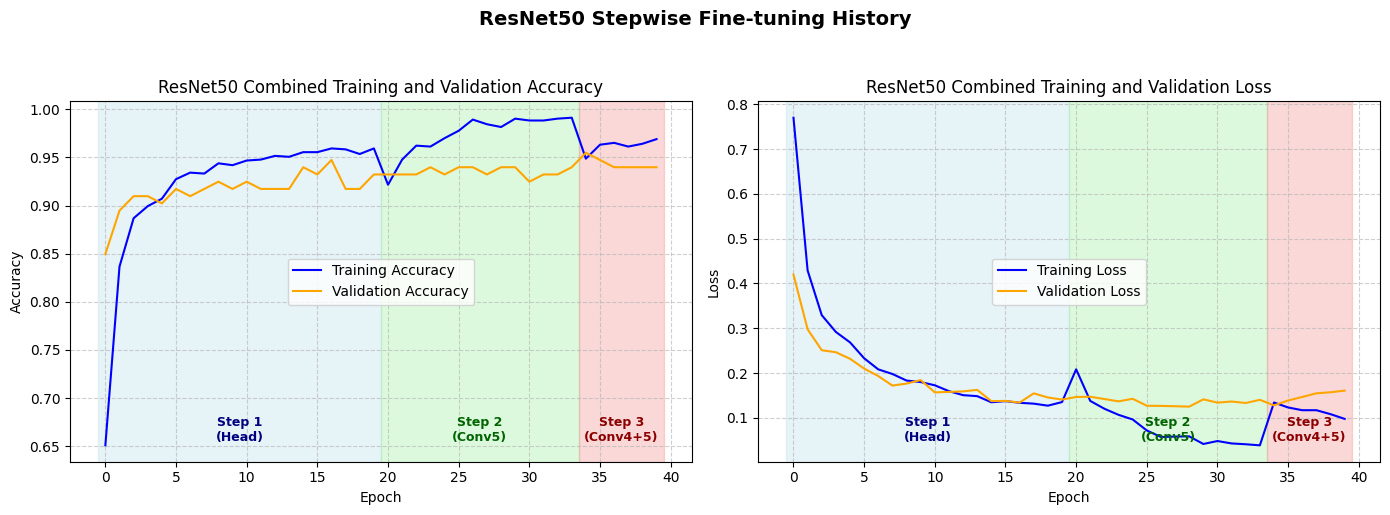

Combined Fine-tuning History Plot with Step Highlights and Saving Complete


In [8]:
# Plot Combined Fine-tuning History for ResNet50 with Step 1, 2, 3 Highlights and Save as TIFF

# Check Step 1, 2, 3 history
if 'step1' in finetuning_history and finetuning_history['step1'] is not None:

    combined_history = {}
    combined_history['accuracy'] = finetuning_history['step1'].get('accuracy', [])
    combined_history['val_accuracy'] = finetuning_history['step1'].get('val_accuracy', [])
    combined_history['loss'] = finetuning_history['step1'].get('loss', [])
    combined_history['val_loss'] = finetuning_history['step1'].get('val_loss', [])

    epochs_step1 = len(combined_history['accuracy'])
    epochs_step2 = 0
    epochs_step3 = 0

    if finetuning_history.get('step2') is not None:
        combined_history['accuracy'].extend(finetuning_history['step2'].get('accuracy', []))
        combined_history['val_accuracy'].extend(finetuning_history['step2'].get('val_accuracy', []))
        combined_history['loss'].extend(finetuning_history['step2'].get('loss', []))
        combined_history['val_loss'].extend(finetuning_history['step2'].get('val_loss', []))
        epochs_step2 = len(finetuning_history['step2'].get('accuracy', []))

    if finetuning_history.get('step3') is not None:
        combined_history['accuracy'].extend(finetuning_history['step3'].get('accuracy', []))
        combined_history['val_accuracy'].extend(finetuning_history['step3'].get('val_accuracy', []))
        combined_history['loss'].extend(finetuning_history['step3'].get('loss', []))
        combined_history['val_loss'].extend(finetuning_history['step3'].get('val_loss', []))
        epochs_step3 = len(finetuning_history['step3'].get('accuracy', []))


    total_epochs = range(len(combined_history['accuracy']))

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(total_epochs, combined_history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(total_epochs, combined_history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('ResNet50 Combined Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add background highlighting and labels for each step
    plt.axvspan(-0.5, epochs_step1 - 0.5, color='lightblue', alpha=0.3, label='Step 1 (Head)')
    if epochs_step1 > 0:
        plt.text(epochs_step1 / 2 - 0.5, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05, 'Step 1\n(Head)',
                 horizontalalignment='center', verticalalignment='bottom', color='navy', fontsize=9, weight='bold')

    if epochs_step2 > 0:
        start_step2 = epochs_step1
        end_step2 = epochs_step1 + epochs_step2
        plt.axvspan(start_step2 - 0.5, end_step2 - 0.5, color='lightgreen', alpha=0.3, label='Step 2 (Conv5)')
        plt.text(start_step2 + epochs_step2 / 2 - 0.5, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05, 'Step 2\n(Conv5)',
                 horizontalalignment='center', verticalalignment='bottom', color='darkgreen', fontsize=9, weight='bold')

    if epochs_step3 > 0:
        start_step3 = epochs_step1 + epochs_step2
        end_step3 = epochs_step1 + epochs_step2 + epochs_step3
        plt.axvspan(start_step3 - 0.5, end_step3 - 0.5, color='lightcoral', alpha=0.3, label='Step 3 (Conv4+5)')
        plt.text(start_step3 + epochs_step3 / 2 - 0.5, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05, 'Step 3\n(Conv4+5)',
                 horizontalalignment='center', verticalalignment='bottom', color='darkred', fontsize=9, weight='bold')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(total_epochs, combined_history['loss'], label='Training Loss', color='blue')
    plt.plot(total_epochs, combined_history['val_loss'], label='Validation Loss', color='orange')
    plt.title('ResNet50 Combined Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='center')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add background highlighting and labels for each step
    plt.axvspan(-0.5, epochs_step1 - 0.5, color='lightblue', alpha=0.3)
    if epochs_step1 > 0:
         plt.text(epochs_step1 / 2 - 0.5, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05, 'Step 1\n(Head)',
                 horizontalalignment='center', verticalalignment='bottom', color='navy', fontsize=9, weight='bold')

    if epochs_step2 > 0:
        start_step2 = epochs_step1
        end_step2 = epochs_step1 + epochs_step2
        plt.axvspan(start_step2 - 0.5, end_step2 - 0.5, color='lightgreen', alpha=0.3)
        plt.text(start_step2 + epochs_step2 / 2 - 0.5, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05, 'Step 2\n(Conv5)',
                 horizontalalignment='center', verticalalignment='bottom', color='darkgreen', fontsize=9, weight='bold')

    if epochs_step3 > 0:
        start_step3 = epochs_step1 + epochs_step2
        end_step3 = epochs_step1 + epochs_step2 + epochs_step3
        plt.axvspan(start_step3 - 0.5, end_step3 - 0.5, color='lightcoral', alpha=0.3)
        plt.text(start_step3 + epochs_step3 / 2 - 0.5, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05, 'Step 3\n(Conv4+5)',
                 horizontalalignment='center', verticalalignment='bottom', color='darkred', fontsize=9, weight='bold')

    plt.suptitle('ResNet50 Stepwise Fine-tuning History', y=1.02, fontsize=14, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    # Save the figure as a TIFF 300 DPI
    filename = 'ResNet50_finetuning_history_highlighted.tiff'
    plt.savefig(filename, format='tiff', dpi=300, bbox_inches='tight')
    print(f"Saved {filename}")

    plt.show()
    plt.close()

else:
    print("Fine-tuning history not found or Step 1 history is missing.")

print("Combined Fine-tuning History Plot with Step Highlights and Saving Complete")

## Plotting Confusion Matrix, Classification Report

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get true labels and predictions for the test set
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1) # Get the predicted class index (highest probability)
    predictions.extend(predicted_classes)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Compute and Print Confusion Matrix
print("Confusion Matrix")
cm = confusion_matrix(true_labels, predictions)
print(cm)

# Compute and Print Classification Report
print("Classification Report")

report = classification_report(true_labels, predictions)
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Confusion Matrix
[[41  2  0]
 [ 4 39  0]
 [ 0  1 41]]
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        43
           1       0.93      0.91      0.92        43
           2       1.00      0.98      0.99        42

    accuracy                           0.95       128
   macro avg       0.95      0.95      0.95       128
weighted avg       0.95      0.95      0.95       128



## Plot Confusion Matrix (Seaborn) 

Saved Figure3_Confusion_Matrix.tiff


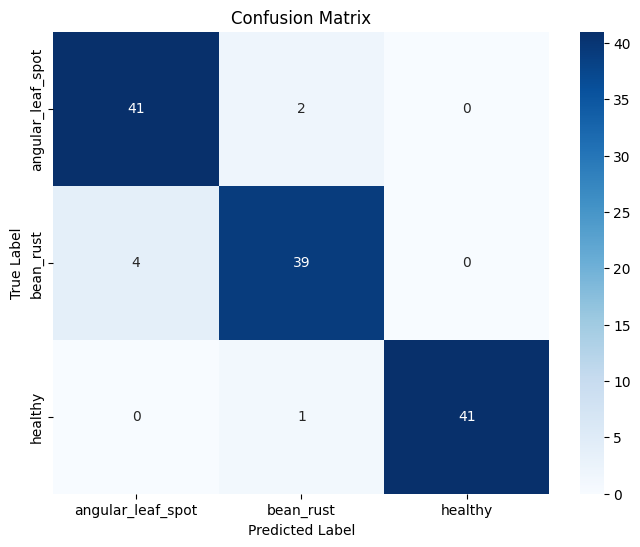

Confusion Matrix Plot Saved


In [10]:
# Plot Confusion Matrix with Seaborn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

# Explicitly create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

# Save the figure in tiff 300 DPI
save_filename = 'Figure3_Confusion_Matrix.tiff'
fig.savefig(save_filename, dpi=300, format='tiff', bbox_inches='tight')
print(f"Saved {save_filename}")
plt.show(fig)
plt.close(fig)

print("Confusion Matrix Plot Saved")

## Save Fine-tuned ResNet50 Model

In [11]:
# Model Saving Step

print("Saving the Fine-tuned Model")

save_path = 'ResNet50_fine_tuned_model.keras'

try:
    model.save(save_path)
    print(f"Model successfully saved to: {save_path}")

except Exception as e:
    print(f"An error occurred while saving the model: {e}")

print("Evaluation and Model Saving Complete")

Saving the Fine-tuned Model
Model successfully saved to: ResNet50_fine_tuned_model.keras
Evaluation and Model Saving Complete
